In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

This ensures that any operations involving randomness in a code (our models that case) will produce the same results every time the notebook is run.

In [2]:
#SEED = 42
#np.random.seed(SEED)
#tf.random.set_seed(SEED)
#random.seed(SEED)

This code loads five different driver datasets,
prints their shapes to check data size
& groups them into a list for easier processing later:

In [3]:
import pandas as pd

# Load datasets
d1 = pd.read_csv("D1_FINAL_10Hz.csv")
d2 = pd.read_csv("D2_FINAL_10Hz.csv")
d3 = pd.read_csv("D3_FINAL_10Hz.csv")
d4 = pd.read_csv("D4_FINAL_10Hz.csv")
d5 = pd.read_csv("D5_FINAL_10Hz.csv")

print(d1.shape)
print(d2.shape)
print(d3.shape)
print(d4.shape)
print(d5.shape)

drivers = [d1, d2, d3, d4, d5]

(42427, 43)
(47168, 43)
(48554, 43)
(50752, 43)
(47046, 43)


This code converts road type to numbers because ML only understands models only understand numbers, then we created a new feature that shows how fast the driver is going relative to the allowed speed:

In [4]:
ROAD_MAP = {
    "motor": 1,
    "secondary": 0
}

for df in [d1, d2, d3, d4, d5]:
    df["road_type"] = df["road_type"].map(ROAD_MAP)
    df["speed_ratio"] = df["speed_kmh"] / df["max_speed"]

In [5]:
print("D1 duplicate rows:", d1.duplicated().sum())
print("D2 duplicate rows:", d2.duplicated().sum())
print("D3 duplicate rows:", d3.duplicated().sum())
print("D4 duplicate rows:", d4.duplicated().sum())
print("D4 duplicate rows:", d5.duplicated().sum())

D1 duplicate rows: 0
D2 duplicate rows: 0
D3 duplicate rows: 0
D4 duplicate rows: 0
D4 duplicate rows: 0


In [6]:
d1 = d1.drop_duplicates().reset_index(drop=True)
d2 = d2.drop_duplicates().reset_index(drop=True)
d3 = d3.drop_duplicates().reset_index(drop=True)
d4 = d4.drop_duplicates().reset_index(drop=True)
d5 = d5.drop_duplicates().reset_index(drop=True)

This code defines the exact input features used for classification:

In [7]:
LABEL_COL = "behavior"

NON_FEATURE_COLS = [
    "t_sec",            #time
    "driver",           #driver id
    LABEL_COL,          #label
    "road_type_osm",
    "road_type",
    "lane_id"
]

def get_feature_columns(df, non_feature_cols):
    return [c for c in df.columns if c not in non_feature_cols]

feature_cols = get_feature_columns(d1, NON_FEATURE_COLS)

print("Number of features:", len(feature_cols))
print(feature_cols)

Number of features: 39
['t_10hz', 'timestamp', 'speed_kmh', 'lat', 'lon', 'alt', 'vert_acc', 'horiz_acc', 'course', 'difcourse', 'hdop', 'vdop', 'pdop', 'active', 'acc_x', 'acc_y', 'acc_z', 'acc_x_kf', 'acc_y_kf', 'acc_z_kf', 'roll', 'pitch', 'yaw', 'x_lane', 'phi', 'road_width', 'lane_state', 'dist_front', 'ttc_front', 'num_vehicles', 'gps_speed', 'max_speed', 'speed_rel', 'num_lanes', 'lat_osm', 'lon_osm', 'osm_delay', 'gps_speed_osm', 'speed_ratio']


In [8]:
motor_drivers = []
secondary_drivers = []

for df in drivers:
    motor_df = df[df["road_type"] == 1].reset_index(drop=True)
    secondary_df = df[df["road_type"] == 0].reset_index(drop=True)

    motor_drivers.append(motor_df)
    secondary_drivers.append(secondary_df)

In [9]:
for i, (m_df, s_df) in enumerate(zip(motor_drivers, secondary_drivers), start=1):
    print(f"D{i} motor rows:", len(m_df))
    print(f"D{i} secondary rows:", len(s_df))
    print("-" * 30)

D1 motor rows: 25688
D1 secondary rows: 16739
------------------------------
D2 motor rows: 27834
D2 secondary rows: 19334
------------------------------
D3 motor rows: 27999
D3 secondary rows: 20555
------------------------------
D4 motor rows: 29789
D4 secondary rows: 20963
------------------------------
D5 motor rows: 28504
D5 secondary rows: 18542
------------------------------


This code tells which column is the class label & defines the exact behaviors:

In [10]:
LABEL_COL = "behavior"
LABEL_ORDER = ["Normal", "Aggressive", "Drowsy"]

We created a helper function to split each driver’s data by driving behavior to ensure clean separation between classes before training.

In [11]:
def split_by_behavior(df, label_col, label_order):
    splits = {}
    for label in label_order:
        part = df[df[label_col] == label].reset_index(drop=True)
        if len(part) > 0:
            splits[label] = part
    return splits

In [12]:
motor_behavior_drivers = []

for i, df in enumerate(motor_drivers, start=1):
    splits = split_by_behavior(df, LABEL_COL, LABEL_ORDER)
    motor_behavior_drivers.append(splits)
    print(f"D{i} MOTOR behaviors:", {k: len(v) for k, v in splits.items()})

D1 MOTOR behaviors: {'Normal': 8749, 'Aggressive': 7450, 'Drowsy': 9489}
D2 MOTOR behaviors: {'Normal': 9550, 'Aggressive': 8776, 'Drowsy': 9508}
D3 MOTOR behaviors: {'Normal': 9288, 'Aggressive': 8414, 'Drowsy': 10297}
D4 MOTOR behaviors: {'Normal': 10071, 'Aggressive': 9401, 'Drowsy': 10317}
D5 MOTOR behaviors: {'Normal': 9273, 'Aggressive': 8047, 'Drowsy': 11184}


In [13]:
secondary_behavior_drivers = []

for i, df in enumerate(secondary_drivers, start=1):
    splits = split_by_behavior(df, LABEL_COL, LABEL_ORDER)
    secondary_behavior_drivers.append(splits)
    print(f"D{i} SECONDARY behaviors:", {k: len(v) for k, v in splits.items()})

D1 SECONDARY behaviors: {'Normal': 6309, 'Aggressive': 5362, 'Drowsy': 5068}
D2 SECONDARY behaviors: {'Normal': 6548, 'Aggressive': 6216, 'Drowsy': 6570}
D3 SECONDARY behaviors: {'Normal': 7060, 'Aggressive': 6830, 'Drowsy': 6665}
D4 SECONDARY behaviors: {'Normal': 7345, 'Aggressive': 6680, 'Drowsy': 6938}
D5 SECONDARY behaviors: {'Normal': 7064, 'Aggressive': 4409, 'Drowsy': 7069}


This code converts behavior labels from text to numbers which is mandatory for ML models:

In [14]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(LABEL_ORDER)

print(dict(zip(label_encoder.classes_,
               label_encoder.transform(label_encoder.classes_))))

{np.str_('Aggressive'): np.int64(0), np.str_('Drowsy'): np.int64(1), np.str_('Normal'): np.int64(2)}


Now this code converts continuous sensor data into fixed-length time windows which are used as training samples.

Each window:

Represents a short driving segment

Has 2400 time steps

Moves forward by 260 steps (overlap)

In [15]:
def window_data(df, window_size, stride, label_encoder):
    X, y = [], []

    feature_values = df[feature_cols].values
    label_values = label_encoder.transform(df[LABEL_COL].values)

    for i in range(0, len(df) - window_size + 1, stride):
        X_window = feature_values[i:i+window_size]
        y_window = label_values[i:i+window_size]

        # Majority label (paper-style)
        majority_label = np.bincount(y_window).argmax()

        X.append(X_window)
        y.append(majority_label)

    return np.array(X), np.array(y)

## THIS IS WINDOWING FOR MOTOR DATA

In this step, we generate windowed motor-road data per driver by first separating behaviors, encoding labels, applying sliding windows & then merging all behavior windows for each driver while preserving driver boundaries.

In [16]:
X_motor_by_driver = []
y_motor_by_driver = []

window_size = 2400
stride = 240

for df_driver in motor_drivers:

    X_tmp, y_tmp = window_data(
        df_driver,
        window_size,
        stride,
        label_encoder
    )

    if len(X_tmp) > 0:
        X_motor_by_driver.append(X_tmp)
        y_motor_by_driver.append(y_tmp)



#X_motor = np.concatenate(X_motor, axis=0)
#y_motor = np.concatenate(y_motor, axis=0)

for i in range(len(X_motor_by_driver)):
    print(f"Driver {i+1} motor windows:", X_motor_by_driver[i].shape)


Driver 1 motor windows: (98, 2400, 39)
Driver 2 motor windows: (106, 2400, 39)
Driver 3 motor windows: (107, 2400, 39)
Driver 4 motor windows: (115, 2400, 39)
Driver 5 motor windows: (109, 2400, 39)


## THIS IS WINDOWING FOR SECONDARY DATA

In [17]:
X_secondary_by_driver = []
y_secondary_by_driver = []

window_size = 2400
stride = 260

for df_driver in secondary_drivers:

    X_tmp, y_tmp = window_data(
        df_driver,
        window_size,
        stride,
        label_encoder
    )

    if len(X_tmp) > 0:
        X_secondary_by_driver.append(X_tmp)
        y_secondary_by_driver.append(y_tmp)


#X_secondary = np.concatenate(X_secondary, axis=0)
#y_secondary = np.concatenate(y_secondary, axis=0)

for i in range(len(X_secondary_by_driver)):
    print(f"Driver {i+1} secondary windows:", X_secondary_by_driver[i].shape)

Driver 1 secondary windows: (56, 2400, 39)
Driver 2 secondary windows: (66, 2400, 39)
Driver 3 secondary windows: (70, 2400, 39)
Driver 4 secondary windows: (72, 2400, 39)
Driver 5 secondary windows: (63, 2400, 39)


In [18]:
# import pandas as pd
# import numpy as np

# motor_rows = []

# for driver_idx, driver_windows in enumerate(X_motor_by_driver):
#     for win_idx, window in enumerate(driver_windows):
#         flat_window = window.flatten()

#         row = {
#             "driver_id": driver_idx + 1,
#             "window_id": win_idx,
#             "road_type": "motor"
#         }

#         for i, val in enumerate(flat_window):
#             row[f"f_{i}"] = val

#         motor_rows.append(row)

# motor_window_df = pd.DataFrame(motor_rows)

In [19]:
# secondary_rows = []

# for driver_idx, driver_windows in enumerate(X_secondary_by_driver):
#     for win_idx, window in enumerate(driver_windows):
#         flat_window = window.flatten()

#         row = {
#             "driver_id": driver_idx + 1,
#             "window_id": win_idx,
#             "road_type": "secondary"
#         }

#         for i, val in enumerate(flat_window):
#             row[f"f_{i}"] = val

#         secondary_rows.append(row)

# secondary_window_df = pd.DataFrame(secondary_rows)

In [20]:
# motor_window_df.to_csv("motor_window_features_10Hz.csv", index=False)
# secondary_window_df.to_csv("secondary_window_features_10Hz.csv", index=False)

## TRAIN - TEST SPLITS FOR MOTOR DATA

In [21]:
from sklearn.model_selection import train_test_split

# ===== DRIVER-BASED SPLIT (MOTOR) =====

#train: drivers 1–3
X_motor_train = np.concatenate(X_motor_by_driver[:3], axis=0)
y_motor_train = np.concatenate(y_motor_by_driver[:3], axis=0)

#test: driver 4-5
X_motor_test = np.concatenate(X_motor_by_driver[3:], axis=0)
y_motor_test = np.concatenate(y_motor_by_driver[3:], axis=0)


#validation split inside training drivers only
X_motor_train, X_motor_val, y_motor_train, y_motor_val = train_test_split(
    X_motor_train,
    y_motor_train,
    test_size=0.3,
    random_state=42,
    stratify=y_motor_train
)

print("Motor TRAIN:", X_motor_train.shape)
print("Motor VAL  :", X_motor_val.shape)
print("Motor TEST :", X_motor_test.shape)


Motor TRAIN: (217, 2400, 39)
Motor VAL  : (94, 2400, 39)
Motor TEST : (224, 2400, 39)


In [22]:
# ===== MOTOR CLASS WEIGHTS =====
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

motor_class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_motor_train),
    y=y_motor_train
)

motor_class_weights = dict(enumerate(motor_class_weights))
print("Motor class weights:", motor_class_weights)

Motor class weights: {0: np.float64(1.1481481481481481), 1: np.float64(0.8611111111111112), 2: np.float64(1.0333333333333334)}


In [23]:
# ===== MOTOR: Window-level balancing (TRAIN ONLY) =====

def balance_windows(X, y):
    X_balanced = []
    y_balanced = []

    classes, counts = np.unique(y, return_counts=True)
    min_count = counts.min()

    for cls in classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        idx = idx[:min_count]

        X_balanced.append(X[idx])
        y_balanced.append(y[idx])

    return np.concatenate(X_balanced), np.concatenate(y_balanced)


print("Motor BEFORE balancing:", np.bincount(y_motor_train))

X_motor_train, y_motor_train = balance_windows(
    X_motor_train, y_motor_train
)

print("Motor AFTER balancing:", np.bincount(y_motor_train))

Motor BEFORE balancing: [63 84 70]
Motor AFTER balancing: [63 63 63]


## MOTOR NORMALIZATION

In this code we normalize windowed data using StandardScaler
fitting only on training samples to avoid data leakage.
The data is flattened for scaling and then reshaped to preserve temporal structure (means the order of sensor readings over time remains unchanged after preprocessing)

In [24]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# ----- MOTOR NORMALIZATION -----

motor_scaler = StandardScaler()

# Ensure float32 for TensorFlow stability
X_motor_train = X_motor_train.astype(np.float32)
X_motor_val   = X_motor_val.astype(np.float32)
X_motor_test  = X_motor_test.astype(np.float32)

# Fit scaler on TRAIN ONLY
X_motor_train_flat = X_motor_train.reshape(-1, X_motor_train.shape[-1])
motor_scaler.fit(X_motor_train_flat)

def scale_windows(X, scaler):
    X_flat = X.reshape(-1, X.shape[-1])
    X_scaled = scaler.transform(X_flat)

    # Safety: remove NaN / inf if any appear
    X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)

    return X_scaled.reshape(X.shape)

# Apply same scaler to all splits
X_motor_train_norm = scale_windows(X_motor_train, motor_scaler)
X_motor_val_norm   = scale_windows(X_motor_val, motor_scaler)
X_motor_test_norm  = scale_windows(X_motor_test, motor_scaler)

print("Motor normalization done:")
print("Train:", X_motor_train_norm.shape)
print("Val:  ", X_motor_val_norm.shape)
print("Test: ", X_motor_test_norm.shape)

# Sanity check (run once)
print("Motor train mean:", np.mean(X_motor_train_norm))
print("Motor train std: ", np.std(X_motor_train_norm))

Motor normalization done:
Train: (189, 2400, 39)
Val:   (94, 2400, 39)
Test:  (224, 2400, 39)
Motor train mean: 3.0507365e-06
Motor train std:  1.0


## TRAIN - TEST SPLITS FOR SECONDARY DATA

In [25]:
# ===== DRIVER-BASED SPLIT (SECONDARY) =====

#train: drivers 1–4
X_secondary_train = np.concatenate(X_secondary_by_driver[:4], axis=0)
y_secondary_train = np.concatenate(y_secondary_by_driver[:4], axis=0)

#test: driver 5
X_secondary_test = np.concatenate(X_secondary_by_driver[4:], axis=0)
y_secondary_test = np.concatenate(y_secondary_by_driver[4:], axis=0)

# validation split from training drivers only
X_secondary_train, X_secondary_val, y_secondary_train, y_secondary_val = train_test_split(
    X_secondary_train,
    y_secondary_train,
    test_size=0.45,
    random_state=42,
    stratify=y_secondary_train
)

print("Secondary TRAIN:", X_secondary_train.shape)
print("Secondary VAL  :", X_secondary_val.shape)
print("Secondary TEST :", X_secondary_test.shape)


Secondary TRAIN: (145, 2400, 39)
Secondary VAL  : (119, 2400, 39)
Secondary TEST : (63, 2400, 39)


In [26]:
# ===== SECONDARY CLASS WEIGHTS =====
secondary_class_weights = compute_class_weight(

    class_weight="balanced",
    classes=np.unique(y_secondary_train),
    y=y_secondary_train
)

secondary_class_weights = dict(enumerate(secondary_class_weights))
print("Secondary class weights:", secondary_class_weights)

Secondary class weights: {0: np.float64(1.0984848484848484), 1: np.float64(0.9119496855345912), 2: np.float64(1.0069444444444444)}


In [27]:
# ===== SECONDARY: Window-level balancing (TRAIN ONLY) =====

def balance_windows(X, y):
    X_balanced = []
    y_balanced = []

    classes, counts = np.unique(y, return_counts=True)
    min_count = counts.min()

    for cls in classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        idx = idx[:min_count]

        X_balanced.append(X[idx])
        y_balanced.append(y[idx])

    return np.concatenate(X_balanced), np.concatenate(y_balanced)


print("Secondary BEFORE balancing:", np.bincount(y_secondary_train))

X_secondary_train, y_secondary_train = balance_windows(
    X_secondary_train, y_secondary_train
)

print("Secondary AFTER balancing:", np.bincount(y_secondary_train))

Secondary BEFORE balancing: [44 53 48]


Secondary AFTER balancing: [44 44 44]


## SECONDARY NORMALIZATION

In [28]:
secondary_scaler = StandardScaler()

X_secondary_train = X_secondary_train.astype(np.float32)
X_secondary_val   = X_secondary_val.astype(np.float32)
X_secondary_test  = X_secondary_test.astype(np.float32)

X_secondary_train_flat = X_secondary_train.reshape(-1, X_secondary_train.shape[-1])
secondary_scaler.fit(X_secondary_train_flat)

X_secondary_train_norm = scale_windows(X_secondary_train, secondary_scaler)
X_secondary_val_norm   = scale_windows(X_secondary_val, secondary_scaler)
X_secondary_test_norm  = scale_windows(X_secondary_test, secondary_scaler)

print("Secondary normalization done:")
print("Train:", X_secondary_train_norm.shape)
print("Val:  ", X_secondary_val_norm.shape)
print("Test: ", X_secondary_test_norm.shape)

print("Secondary train mean:", np.mean(X_secondary_train_norm))
print("Secondary train std: ", np.std(X_secondary_train_norm))

Secondary normalization done:
Train: (132, 2400, 39)
Val:   (119, 2400, 39)
Test:  (63, 2400, 39)
Secondary train mean: 7.45511e-07
Secondary train std:  1.0


### NOW WE ARE DONE WITH PREPROCESSING AND WINDOWING FOR BOTH MOTOR AND SECONDARY

This model combines 2 ideas:
LSTM to understand how driving changes over time
& CNN (FCN) to detect important local motion patterns in sensor data.

We define the model as a function so it can be reused with different datasets.

Each input sample is a sequence of sensor readings over time. (the windows that we created)

The CNN part learns short-term driving patterns like acceleration or braking by sliding filters over time.

In [29]:
from tensorflow.keras.layers import (
    Input,
    LSTM,
    Conv1D,
    BatchNormalization,
    Activation,
    GlobalAveragePooling1D,
    Dense,
    Dropout
)
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.losses import SparseCategoricalCrossentropy



def build_lstm_fcn(input_shape, num_classes):
    """
    LSTM-FCN model
    input_shape = (timesteps, features)
    num_classes = number of behavior classes (3)
    """

    inputs = Input(shape=input_shape)

    # ----- LSTM branch -----
    lstm_out = LSTM(
        units=64,
        dropout=0.2,
        recurrent_dropout=0.0,
        return_sequences=False
    )(inputs)

    #Reads the window step by step, remembers important trends and then outputs one summary vector per window
    #for example: Gradual drowsiness, sustained aggressive driving & speed trends over time.

    # ----- FCN branch -----
    x = Conv1D(filters=128, kernel_size=8, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv1D(filters=256, kernel_size=5, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv1D(filters=128, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = GlobalAveragePooling1D()(x)

    # ----- Merge LSTM + FCN -----
    merged = Concatenate()([lstm_out, x])
    merged = Dense(128, activation="relu")(merged)
    merged = Dropout(0.2)(merged)

    outputs = Dense(num_classes, activation="softmax")(merged)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=3e-4),loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    return model

## TRAIN MOTOR MODEL

In [30]:
# motor_model = build_lstm_fcn(
#     input_shape=X_motor_train_norm.shape[1:],
#     num_classes=3
# )

# motor_model.summary()

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_macro_f1",
    mode="max",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [32]:
from tensorflow.keras.models import load_model

motor_model = load_model("../models/motor_model.keras", compile=False)

print("Motor model loaded (frozen).")

Motor model loaded (frozen).


In [33]:
motor_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [34]:
# history = motor_model.fit(
    # X_motor_train_norm,
    # y_motor_train,
    # validation_data=(X_motor_val_norm, y_motor_val),
    # epochs=50,
    # batch_size=15,
    # class_weight=motor_class_weights,
    # callbacks=[early_stop],
    # verbose=1
# )

In [35]:
motor_test_loss, motor_test_acc = motor_model.evaluate(
    X_motor_test_norm,
    y_motor_test,
    verbose=1
)

print("MOTOR Test accuracy:", motor_test_acc)
print("MOTOR Test loss:", motor_test_loss)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.8616 - loss: 1.3029
MOTOR Test accuracy: 0.8616071343421936
MOTOR Test loss: 1.3029440641403198


## TRAIN SECONDARY MODEL

In [36]:
# secondary_model = build_lstm_fcn(
#     input_shape=X_secondary_train_norm.shape[1:],
#     num_classes=3
# )

# secondary_model.summary()

In [37]:
# history_secondary = secondary_model.fit(
    # X_secondary_train_norm,
    # y_secondary_train,
    # validation_data=(X_secondary_val_norm, y_secondary_val),
    # epochs=40,
    # batch_size=10,
    # callbacks=[early_stop],
    # class_weight=secondary_class_weights,
    # verbose=1
# )


In [38]:
from tensorflow.keras.models import load_model

secondary_model = load_model("../models/secondary_model.keras", compile=False)

print("Secondary model loaded.")

Secondary model loaded.


In [39]:
secondary_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [40]:
secondary_test_loss, secondary_test_acc = secondary_model.evaluate(
    X_secondary_test_norm,
    y_secondary_test,
    verbose=1
)

print("SECONDARY Test accuracy:", secondary_test_acc)
print("SECONDARY Test loss:", secondary_test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 0.9524 - loss: 0.0758
SECONDARY Test accuracy: 0.9523809552192688
SECONDARY Test loss: 0.07582176476716995


In [41]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step


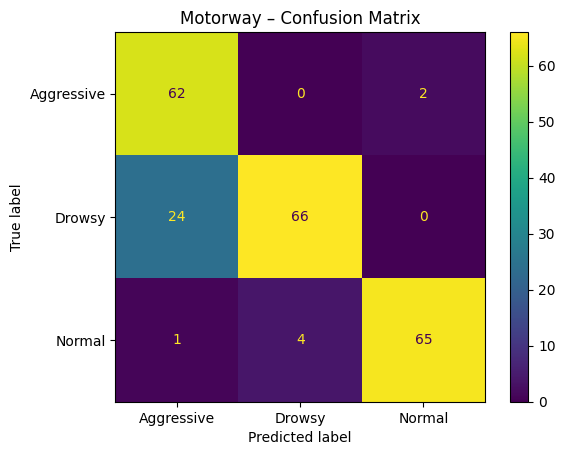

In [42]:
# ----- MOTOR MODEL -----

#predict probabilities
y_motor_pred_prob = motor_model.predict(X_motor_test_norm)

#convert to class labels
import numpy as np
y_motor_pred = np.argmax(y_motor_pred_prob, axis=1)

#true labels
y_motor_true = y_motor_test

#confusion matrix
cm_motor = confusion_matrix(y_motor_true, y_motor_pred)

disp_motor = ConfusionMatrixDisplay(
    confusion_matrix=cm_motor,
    display_labels=["Aggressive", "Drowsy", "Normal"]
)

disp_motor.plot(cmap="viridis")
plt.title("Motorway – Confusion Matrix")
plt.show()


In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_motor_true, y_motor_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7126    0.9688    0.8212        64
           1     0.9429    0.7333    0.8250        90
           2     0.9701    0.9286    0.9489        70

    accuracy                         0.8616       224
   macro avg     0.8752    0.8769    0.8650       224
weighted avg     0.8856    0.8616    0.8626       224



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


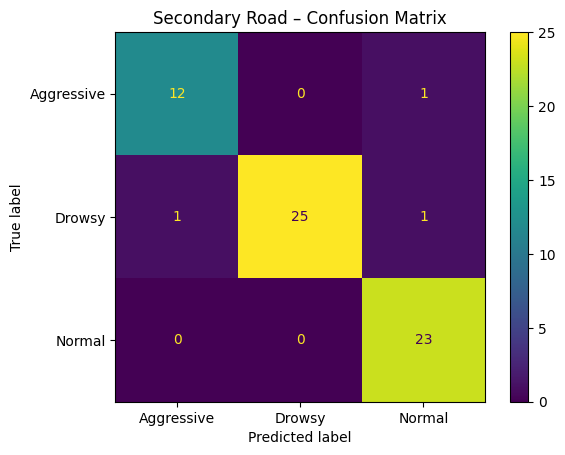

In [44]:
# ----- SECONDARY MODEL -----

#predict probabilities
y_secondary_pred_prob = secondary_model.predict(X_secondary_test_norm)

#convert to class labels
y_secondary_pred = np.argmax(y_secondary_pred_prob, axis=1)

#true labels
y_secondary_true = y_secondary_test

#confusion matrix
cm_secondary = confusion_matrix(y_secondary_true, y_secondary_pred)

disp_secondary = ConfusionMatrixDisplay(
    confusion_matrix=cm_secondary,
    display_labels=["Aggressive", "Drowsy", "Normal"]
)

disp_secondary.plot(cmap="viridis")
plt.title("Secondary Road – Confusion Matrix")
plt.show()

this function applies majority voting across nearby windows to reduce noisy, isolated misclassifications.

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_secondary_true, y_secondary_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9231    0.9231    0.9231        13
           1     1.0000    0.9259    0.9615        27
           2     0.9200    1.0000    0.9583        23

    accuracy                         0.9524        63
   macro avg     0.9477    0.9497    0.9476        63
weighted avg     0.9549    0.9524    0.9524        63



## SAVING THE MODELS

In [46]:
#from google.colab import drive
#drive.mount('/content/drive')

In [47]:
# secondary_model.save("secondary_model.keras")
# print("Secondary model saved.")

In [48]:
# motor_model.save("motor_model.keras")
# print("Motor model saved.")

In [49]:
# import joblib

# joblib.dump(motor_scaler, "motor_scaler.pkl")
# joblib.dump(secondary_scaler, "secondary_scaler.pkl")

In [50]:
# import json

# feature_schema = {
#     "sampling_rate_hz": 10,
#     "window_length": 2400,
#     "num_features": 39,
#     "feature_order": feature_cols  # list you used in training
# }

# json.dump(feature_schema, open("feature_schema.json", "w"), indent=2)
# print("Feature schema saved.")

In [53]:
import sys
import os

sys.path.append(os.path.abspath("../"))

from src.classify import predict_motor

sample_window = X_motor_test[57]

result = predict_motor(sample_window)
print("Prediction:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Prediction: Drowsy


In [54]:
import sys
import os

sys.path.append(os.path.abspath("../"))

from src.pipeline import process_window

sample_window = X_motor_test[0]

result = process_window(sample_window, road_type="motor")

print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
{'road_type': 'motor', 'label': 'Aggressive', 'performance_score': None, 'alerts': [], 'recommendation': None}
